# Real data, v0

This notebook is a first attempt at running the model on the O'Neil dataset.

I'll not do anything clever with the kernels, just want to get a basic thing up and running, with the LMC, permutation invariance and SVI all working together.


But I'll start it off with modelling several drug combinations for a single cell line, i.e. a single-output permutation invariant GP. I'll use a basic fingerprint to represent the drugs, and then PCA to get the dimensionality down.

In [1]:
import pandas as pd
import numpy as np
import gauche
from gauche.dataloader import MolPropLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
loader = MolPropLoader()
drugs = pd.read_csv("../synpred/data/ONeil_drug_SMILES.csv")
data = pd.read_csv("../synpred/data/Oneil_full.csv",delimiter=";")

In [2]:
# Processing drug SMILES
loader.read_csv("../synpred/data/ONeil_drug_SMILES.csv",smiles_column="SMILES",label_column="Numeric",validate=True)
loader.featurize('ecfp_fingerprints')
X = loader.features
scaler = StandardScaler()
X = scaler.fit_transform(X)
pcacomponents = 20
pca = PCA(n_components=pcacomponents)
X = pca.fit_transform(X)
print("ratio variance explained: ",pca.explained_variance_ratio_.sum())

# Merging onto the main dataframe
X = pd.DataFrame(X)
X = X.apply(zscore)
XA = X.add_prefix("A")
XB = X.add_prefix("B")
drugsA = pd.concat([drugs,XA],axis=1)
drugsA = drugsA.drop(columns=["Target","SMILES","Numeric"],axis=1)
drugsB = pd.concat([drugs,XB],axis=1)
drugsB = drugsB.drop(columns=["Target","SMILES","Numeric"],axis=1)
data = pd.merge(data,drugsA, left_on="DrugA",right_on="Name")
data = pd.merge(data,drugsB, left_on="DrugB",right_on="Name")
data = data.drop(columns=["Name_x","Name_y"])

ratio variance explained:  0.7247800651447511


In [3]:
data = data.sort_values(["CellLine","DrugA","DrugB"])

In [4]:
# Now let's subsample this, so that we have a single cell line of data to train on.
k = 2*583*100
#k = 1*583*100
data = data.head(k)

In [5]:
data.shape

(116600, 52)

In [6]:
data["CellLine"].unique()

array(['A2058', 'A2780'], dtype=object)

In [7]:
data

,CellLine,DrugA,DrugB,DrugAconc,DrugBconc,GPMean,GPVar,fMean,fVAR,p0Mean,...,B10,B11,B12,B13,B14,B15,B16,B17,B18,B19
0,A2058,5-FU,ABT-888,0.0,0.000000,-0.086238,0.769223,0.999311,0.000007,0.999129,...,-0.021870,-0.425135,-0.261722,-0.005915,0.397240,-0.369783,-0.169049,0.269443,0.327526,-0.333888
1,A2058,5-FU,ABT-888,0.0,0.111111,-0.109674,0.765477,0.999055,0.000011,0.998892,...,-0.021870,-0.425135,-0.261722,-0.005915,0.397240,-0.369783,-0.169049,0.269443,0.327526,-0.333888
2,A2058,5-FU,ABT-888,0.0,0.222222,-0.137490,0.769211,0.998608,0.000018,0.998559,...,-0.021870,-0.425135,-0.261722,-0.005915,0.397240,-0.369783,-0.169049,0.269443,0.327526,-0.333888
3,A2058,5-FU,ABT-888,0.0,0.333333,-0.169852,0.751210,0.997828,0.000034,0.998071,...,-0.021870,-0.425135,-0.261722,-0.005915,0.397240,-0.369783,-0.169049,0.269443,0.327526,-0.333888
4,A2058,5-FU,ABT-888,0.0,0.444444,-0.209794,0.726083,0.996413,0.000075,0.997321,...,-0.021870,-0.425135,-0.261722,-0.005915,0.397240,-0.369783,-0.169049,0.269443,0.327526,-0.333888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102295,A2780,geldanamycin,Topotecan,1.0,0.555556,-0.100427,0.282582,0.009367,0.000023,0.009645,...,0.279831,1.830699,-1.430091,-0.634910,-0.164416,0.585622,-0.698748,0.408847,-0.004657,-0.426757
2102296,A2780,geldanamycin,Topotecan,1.0,0.666667,0.347319,0.279556,0.007129,0.000013,0.004636,...,0.279831,1.830699,-1.430091,-0.634910,-0.164416,0.585622,-0.698748,0.408847,-0.004657,-0.426757
2102297,A2780,geldanamycin,Topotecan,1.0,0.777778,0.704136,0.306436,0.005793,0.000009,0.002564,...,0.279831,1.830699,-1.430091,-0.634910,-0.164416,0.585622,-0.698748,0.408847,-0.004657,-0.426757
2102298,A2780,geldanamycin,Topotecan,1.0,0.888889,0.823846,0.340308,0.005064,0.000008,0.001912,...,0.279831,1.830699,-1.430091,-0.634910,-0.164416,0.585622,-0.698748,0.408847,-0.004657,-0.426757


In [8]:
data["DrugB"].unique()

array(['ABT-888', 'AZD1775', 'BEZ-235', 'Bortezomib', 'Dasatinib',
       'Dinaciclib', 'Erlotinib', 'L778123', 'Lapatinib', 'MK-2206',
       'MK-4827', 'MK-5108', 'MK-8669', 'MK-8776', 'PD325901',
       'Sorafenib', 'Sunitinib', 'Temozolomide', 'Zolinza',
       'geldanamycin', 'Oxaliplatin', 'SN-38', 'Topotecan', 'Etoposide',
       'Gemcitabine', 'Vinorelbine', '5-FU', 'Carboplatin',
       'Cyclophosphamide', 'Dexamethasone', 'Doxorubicin', 'MRK-003',
       'Metformin', 'Methotrexate', 'Mitomycine', 'Paclitaxel',
       'Vinblastine'], dtype=object)

In [9]:
# Now setting up code to run models
from matplotlib import pyplot as plt
import torch
import gpytorch
import numpy as np
import linear_operator
y = torch.tensor(data["fMean"].values).float()
s = torch.tensor(data["GPVar"].values).float()
conc = data[['DrugAconc','DrugBconc']]
drugcovars = data.iloc[:,-40:]
X = torch.tensor(pd.concat([conc,drugcovars],axis=1).values).float()
n_train = int(0.8*X.size(0))
randperm = torch.randperm(X.size(0))
X_train = X[randperm[:n_train],:]
X_test = X[randperm[n_train:],:]
y_train = y[randperm[:n_train]]
y_test = y[randperm[n_train:]]
task_indices = torch.tensor(pd.Categorical(data['CellLine']).codes).long()
task_train = task_indices[randperm[:n_train]]
task_test = task_indices[randperm[n_train:]]
num_tasks = task_indices.max().item() + 1

In [10]:
X_test.shape

torch.Size([23320, 42])

In [17]:

# Now going to get it ready for minibatching
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, y_train, task_train)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [18]:
X_train.size(1)

42

In [19]:
from synpred.variational.permutation_invariant_variational_strategy import PermutationInvariantVariationalStrategy
from gpytorch.variational import LMCVariationalStrategy

class DrugCombModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        print("Init is run!")
        num_latents = 2
        # Permutation
        permutation = torch.cat([torch.tensor([1]),torch.tensor([0]),torch.linspace(22,41,20),torch.linspace(2,21,20)]).long()
        # Inducing points init from training data
        ind_indices = torch.randperm(X_train.size(0))
        inducing_points = torch.stack([X_train[ind_indices[:3000]],
                                       X_train[ind_indices[3000:6000]]],
                                       #X_train[ind_indices[2000:3000]],
                                       #X_train[ind_indices[3000:4000]]],
                                       dim=0)
        # Variational distribution
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents]))
        
        
        # Variational Strategy
        variational_strategy = LMCVariationalStrategy(
            PermutationInvariantVariationalStrategy(
                self, inducing_points, variational_distribution, 
                permutation=permutation,
                learn_inducing_locations=True),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1)

        
        super(DrugCombModel,self).__init__(variational_strategy)
        
        # Mean and covariance modules
        # Standard zero-mean
        self.mean_module = gpytorch.means.ZeroMean(batch_shape=torch.Size([num_latents]))
        # Covar over the concentrations, simple RBF
        self.covar_module_concentrations = gpytorch.kernels.RBFKernel(active_dims=torch.tensor([0,1]),
                                                                     batch_shape=torch.Size([num_latents]))
        # Covar over the drugs, RBF + ARD
        self.covar_module_drugs = gpytorch.kernels.RBFKernel(active_dims=torch.linspace(2,41,40).long(),
                                                            ard_num_dims=40,
                                                            batch_shape=torch.Size([num_latents]))
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        # Final covariance is a simple product.
        covar_x = self.covar_module_concentrations(x) * self.covar_module_drugs(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
model = DrugCombModel()
likelihood = gpytorch.likelihoods.GaussianLikelihood()

Init is run!


In [20]:
L = model.variational_strategy.base_variational_strategy.inducing_points

In [21]:
torch.unique(L,dim=0,sorted=False)

tensor([[[ 0.0000,  0.1111,  0.0389,  ...,  0.3847, -0.8619,  0.2519],
         [ 0.2222,  0.2222, -0.1797,  ...,  0.0797,  1.0889, -1.8697],
         [ 0.5556,  0.5556, -0.1302,  ..., -0.5225,  0.2174,  0.2525],
         ...,
         [ 0.1111,  0.7778, -0.0978,  ...,  0.0797,  1.0889, -1.8697],
         [ 0.1111,  0.0000, -0.2609,  ..., -0.8552, -1.0621,  3.3411],
         [ 0.4444,  1.0000, -0.2760,  ...,  0.2694,  0.3275, -0.3339]],

        [[ 0.7778,  0.1111, -0.2201,  ..., -0.0315,  0.0090,  0.0178],
         [ 0.0000,  0.7778, -0.2201,  ...,  0.2588,  0.0093,  0.1750],
         [ 1.0000,  0.7778, -0.3122,  ..., -0.0315,  0.0090,  0.0178],
         ...,
         [ 0.6667,  0.5556, -0.2201,  ...,  0.2660,  3.4312, -0.0267],
         [ 0.7778,  0.6667, -0.1527,  ..., -0.8552, -1.0621,  3.3411],
         [ 0.2222,  0.0000, -0.3573,  ..., -0.1621, -1.1258, -0.0561]]],
       grad_fn=<UniqueDimBackward0>)

In [23]:
# this is for running the notebook in our testing framework
import os
import tqdm.notebook
from torch.optim.lr_scheduler import MultiStepLR
num_epochs = 20 # Number of complete passes through the data


model.train()
likelihood.train()

variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), lr=0.1,
                                               num_data=y_train.size(0))

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)
scheduler_variational = MultiStepLR(variational_ngd_optimizer, milestones=[0.5 * num_epochs,
                                                                           0.75 * num_epochs
                                                                           ], gamma=0.1)
scheduler_hypers = MultiStepLR(hyperparameter_optimizer, milestones=[0.5 * num_epochs,
                                                                     0.75 * num_epochs
                                                                     ], gamma=0.1)


# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
with gpytorch.settings.cholesky_max_tries(3):
    epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
        counter = 0
        for x_batch, y_batch, task_batch in minibatch_iter:
            if (counter==5): # Update Variational parameters only every 5th iteration
                ### Perform NGD step to optimize variational parameters
                variational_ngd_optimizer.zero_grad()
                output = model(x_batch,task_indices=task_batch)
                loss = -mll(output, y_batch)
                loss.backward()
                variational_ngd_optimizer.step()
                counter = 0

            ### Perform Adam step to optimize hyperparameters
            hyperparameter_optimizer.zero_grad()
            output = model(x_batch,task_indices=task_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            hyperparameter_optimizer.step()

            counter += 1
            print(model.variational_strategy.lmc_coefficients)
            
            minibatch_iter.set_postfix(loss=loss.item())
        
        scheduler_hypers.step()
        scheduler_variational.step()
        

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-1.0728,  2.4694],
        [ 0.1931,  0.3915]], requires_grad=True)
Parameter containing:
tensor([[-1.0628,  2.4594],
        [ 0.1831,  0.3815]], requires_grad=True)
Parameter containing:
tensor([[-1.0528,  2.4493],
        [ 0.1732,  0.3715]], requires_grad=True)
Parameter containing:
tensor([[-1.0429,  2.4393],
        [ 0.1633,  0.3615]], requires_grad=True)
Parameter containing:
tensor([[-1.0330,  2.4293],
        [ 0.1536,  0.3516]], requires_grad=True)
Parameter containing:
tensor([[-1.0234,  2.4198],
        [ 0.1439,  0.3417]], requires_grad=True)
Parameter containing:
tensor([[-1.0139,  2.4102],
        [ 0.1350,  0.3335]], requires_grad=True)
Parameter containing:
tensor([[-1.0045,  2.4007],
        [ 0.1268,  0.3274]], requires_grad=True)
Parameter containing:
tensor([[-0.9951,  2.3912],
        [ 0.1193,  0.3227]], requires_grad=True)
Parameter containing:
tensor([[-0.9859,  2.3817],
        [ 0.1131,  0.3193]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.5394,  1.8803],
        [ 0.1899,  0.1680]], requires_grad=True)
Parameter containing:
tensor([[-0.5351,  1.8750],
        [ 0.1904,  0.1675]], requires_grad=True)
Parameter containing:
tensor([[-0.5308,  1.8697],
        [ 0.1909,  0.1668]], requires_grad=True)
Parameter containing:
tensor([[-0.5266,  1.8645],
        [ 0.1911,  0.1661]], requires_grad=True)
Parameter containing:
tensor([[-0.5224,  1.8592],
        [ 0.1911,  0.1655]], requires_grad=True)
Parameter containing:
tensor([[-0.5183,  1.8540],
        [ 0.1909,  0.1649]], requires_grad=True)
Parameter containing:
tensor([[-0.5141,  1.8487],
        [ 0.1907,  0.1646]], requires_grad=True)
Parameter containing:
tensor([[-0.5100,  1.8435],
        [ 0.1902,  0.1642]], requires_grad=True)
Parameter containing:
tensor([[-0.5059,  1.8383],
        [ 0.1901,  0.1640]], requires_grad=True)
Parameter containing:
tensor([[-0.5019,  1.8331],
        [ 0.1899,  0.1637]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.2644,  1.4698],
        [ 0.2041,  0.1512]], requires_grad=True)
Parameter containing:
tensor([[-0.2618,  1.4652],
        [ 0.2047,  0.1510]], requires_grad=True)
Parameter containing:
tensor([[-0.2593,  1.4606],
        [ 0.2050,  0.1509]], requires_grad=True)
Parameter containing:
tensor([[-0.2568,  1.4560],
        [ 0.2050,  0.1509]], requires_grad=True)
Parameter containing:
tensor([[-0.2543,  1.4514],
        [ 0.2047,  0.1507]], requires_grad=True)
Parameter containing:
tensor([[-0.2518,  1.4467],
        [ 0.2043,  0.1506]], requires_grad=True)
Parameter containing:
tensor([[-0.2493,  1.4420],
        [ 0.2040,  0.1506]], requires_grad=True)
Parameter containing:
tensor([[-0.2469,  1.4373],
        [ 0.2034,  0.1505]], requires_grad=True)
Parameter containing:
tensor([[-0.2444,  1.4327],
        [ 0.2029,  0.1504]], requires_grad=True)
Parameter containing:
tensor([[-0.2419,  1.4281],
        [ 0.2026,  0.1502]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.2229,  1.3918],
        [ 0.2055,  0.1486]], requires_grad=True)
Parameter containing:
tensor([[-0.2206,  1.3873],
        [ 0.2060,  0.1484]], requires_grad=True)
Parameter containing:
tensor([[-0.2184,  1.3828],
        [ 0.2064,  0.1482]], requires_grad=True)
Parameter containing:
tensor([[-0.2161,  1.3783],
        [ 0.2069,  0.1479]], requires_grad=True)
Parameter containing:
tensor([[-0.2139,  1.3738],
        [ 0.2071,  0.1476]], requires_grad=True)
Parameter containing:
tensor([[-0.2117,  1.3693],
        [ 0.2072,  0.1472]], requires_grad=True)
Parameter containing:
tensor([[-0.2095,  1.3648],
        [ 0.2069,  0.1468]], requires_grad=True)
Parameter containing:
tensor([[-0.2073,  1.3603],
        [ 0.2066,  0.1464]], requires_grad=True)
Parameter containing:
tensor([[-0.2051,  1.3558],
        [ 0.2059,  0.1462]], requires_grad=True)
Parameter containing:
tensor([[-0.2029,  1.3513],
        [ 0.2047,  0.1461]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0784,  1.0349],
        [ 0.2041,  0.1377]], requires_grad=True)
Parameter containing:
tensor([[-0.0771,  1.0308],
        [ 0.2045,  0.1371]], requires_grad=True)
Parameter containing:
tensor([[-0.0759,  1.0267],
        [ 0.2049,  0.1365]], requires_grad=True)
Parameter containing:
tensor([[-0.0746,  1.0227],
        [ 0.2049,  0.1360]], requires_grad=True)
Parameter containing:
tensor([[-0.0734,  1.0186],
        [ 0.2050,  0.1356]], requires_grad=True)
Parameter containing:
tensor([[-0.0721,  1.0145],
        [ 0.2053,  0.1352]], requires_grad=True)
Parameter containing:
tensor([[-0.0709,  1.0104],
        [ 0.2049,  0.1352]], requires_grad=True)
Parameter containing:
tensor([[-0.0697,  1.0064],
        [ 0.2044,  0.1351]], requires_grad=True)
Parameter containing:
tensor([[-0.0685,  1.0024],
        [ 0.2041,  0.1353]], requires_grad=True)
Parameter containing:
tensor([[-0.0673,  0.9984],
        [ 0.2039,  0.1354]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0013,  0.7128],
        [ 0.1983,  0.1322]], requires_grad=True)
Parameter containing:
tensor([[-6.6724e-04,  7.0912e-01],
        [ 1.9898e-01,  1.3205e-01]], requires_grad=True)
Parameter containing:
tensor([[-3.7884e-05,  7.0540e-01],
        [ 1.9996e-01,  1.3224e-01]], requires_grad=True)
Parameter containing:
tensor([[5.9949e-04, 7.0170e-01],
        [2.0174e-01, 1.3245e-01]], requires_grad=True)
Parameter containing:
tensor([[0.0012, 0.6980],
        [0.2034, 0.1325]], requires_grad=True)
Parameter containing:
tensor([[0.0018, 0.6943],
        [0.2043, 0.1324]], requires_grad=True)
Parameter containing:
tensor([[0.0024, 0.6906],
        [0.2037, 0.1323]], requires_grad=True)
Parameter containing:
tensor([[0.0030, 0.6870],
        [0.2024, 0.1320]], requires_grad=True)
Parameter containing:
tensor([[0.0035, 0.6834],
        [0.2001, 0.1321]], requires_grad=True)
Parameter containing:
tensor([[0.0041, 0.6797],
        [0.1980, 0.1319]], requires_g

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[0.0086, 0.6512],
        [0.1999, 0.1286]], requires_grad=True)
Parameter containing:
tensor([[0.0091, 0.6476],
        [0.2003, 0.1284]], requires_grad=True)
Parameter containing:
tensor([[0.0096, 0.6441],
        [0.1998, 0.1285]], requires_grad=True)
Parameter containing:
tensor([[0.0101, 0.6405],
        [0.1989, 0.1286]], requires_grad=True)
Parameter containing:
tensor([[0.0106, 0.6369],
        [0.1978, 0.1288]], requires_grad=True)
Parameter containing:
tensor([[0.0111, 0.6334],
        [0.1963, 0.1289]], requires_grad=True)
Parameter containing:
tensor([[0.0116, 0.6298],
        [0.1953, 0.1292]], requires_grad=True)
Parameter containing:
tensor([[0.0121, 0.6262],
        [0.1960, 0.1300]], requires_grad=True)
Parameter containing:
tensor([[0.0126, 0.6227],
        [0.1967, 0.1309]], requires_grad=True)
Parameter containing:
tensor([[0.0131, 0.6192],
        [0.1976, 0.1321]], requires_grad=True)
Parameter containing:
tensor([[0.0136, 0.6157],
  

Parameter containing:
tensor([[0.0361, 0.3629],
        [0.1738, 0.1306]], requires_grad=True)
Parameter containing:
tensor([[0.0362, 0.3600],
        [0.1726, 0.1299]], requires_grad=True)
Parameter containing:
tensor([[0.0363, 0.3570],
        [0.1736, 0.1293]], requires_grad=True)
Parameter containing:
tensor([[0.0365, 0.3541],
        [0.1763, 0.1285]], requires_grad=True)
Parameter containing:
tensor([[0.0366, 0.3511],
        [0.1788, 0.1274]], requires_grad=True)
Parameter containing:
tensor([[0.0367, 0.3482],
        [0.1798, 0.1269]], requires_grad=True)
Parameter containing:
tensor([[0.0368, 0.3452],
        [0.1796, 0.1263]], requires_grad=True)
Parameter containing:
tensor([[0.0369, 0.3423],
        [0.1783, 0.1261]], requires_grad=True)
Parameter containing:
tensor([[0.0369, 0.3395],
        [0.1760, 0.1260]], requires_grad=True)
Parameter containing:
tensor([[0.0369, 0.3366],
        [0.1734, 0.1260]], requires_grad=True)
Parameter containing:
tensor([[0.0369, 0.3337],
  

Parameter containing:
tensor([[0.0176, 0.1403],
        [0.1319, 0.1113]], requires_grad=True)
Parameter containing:
tensor([[0.0171, 0.1384],
        [0.1307, 0.1121]], requires_grad=True)
Parameter containing:
tensor([[0.0167, 0.1365],
        [0.1330, 0.1112]], requires_grad=True)
Parameter containing:
tensor([[0.0161, 0.1346],
        [0.1329, 0.1098]], requires_grad=True)
Parameter containing:
tensor([[0.0156, 0.1327],
        [0.1316, 0.1084]], requires_grad=True)
Parameter containing:
tensor([[0.0150, 0.1308],
        [0.1309, 0.1086]], requires_grad=True)
Parameter containing:
tensor([[0.0145, 0.1290],
        [0.1304, 0.1087]], requires_grad=True)
Parameter containing:
tensor([[0.0139, 0.1271],
        [0.1274, 0.1077]], requires_grad=True)
Parameter containing:
tensor([[0.0133, 0.1253],
        [0.1299, 0.1099]], requires_grad=True)


Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[0.0128, 0.1235],
        [0.1306, 0.1123]], requires_grad=True)
Parameter containing:
tensor([[0.0121, 0.1217],
        [0.1307, 0.1127]], requires_grad=True)
Parameter containing:
tensor([[0.0116, 0.1199],
        [0.1308, 0.1094]], requires_grad=True)
Parameter containing:
tensor([[0.0111, 0.1181],
        [0.1286, 0.1050]], requires_grad=True)
Parameter containing:
tensor([[0.0107, 0.1163],
        [0.1270, 0.1023]], requires_grad=True)
Parameter containing:
tensor([[0.0102, 0.1147],
        [0.1260, 0.1014]], requires_grad=True)
Parameter containing:
tensor([[0.0098, 0.1130],
        [0.1285, 0.1029]], requires_grad=True)
Parameter containing:
tensor([[0.0094, 0.1115],
        [0.1286, 0.1053]], requires_grad=True)
Parameter containing:
tensor([[0.0090, 0.1099],
        [0.1263, 0.1069]], requires_grad=True)
Parameter containing:
tensor([[0.0086, 0.1083],
        [0.1209, 0.1066]], requires_grad=True)
Parameter containing:
tensor([[0.0082, 0.1068],
  

Parameter containing:
tensor([[-0.0181,  0.0396],
        [ 0.1057,  0.0933]], requires_grad=True)
Parameter containing:
tensor([[-0.0185,  0.0393],
        [ 0.1061,  0.0929]], requires_grad=True)
Parameter containing:
tensor([[-0.0187,  0.0389],
        [ 0.1063,  0.0943]], requires_grad=True)
Parameter containing:
tensor([[-0.0187,  0.0386],
        [ 0.1053,  0.0927]], requires_grad=True)
Parameter containing:
tensor([[-0.0185,  0.0383],
        [ 0.1063,  0.0917]], requires_grad=True)
Parameter containing:
tensor([[-0.0185,  0.0379],
        [ 0.1061,  0.0914]], requires_grad=True)
Parameter containing:
tensor([[-0.0186,  0.0377],
        [ 0.1049,  0.0930]], requires_grad=True)
Parameter containing:
tensor([[-0.0190,  0.0374],
        [ 0.1026,  0.0930]], requires_grad=True)
Parameter containing:
tensor([[-0.0190,  0.0371],
        [ 0.1041,  0.0913]], requires_grad=True)
Parameter containing:
tensor([[-0.0187,  0.0369],
        [ 0.1069,  0.0893]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0267,  0.0285],
        [ 0.0953,  0.0836]], requires_grad=True)
Parameter containing:
tensor([[-0.0279,  0.0287],
        [ 0.0898,  0.0834]], requires_grad=True)
Parameter containing:
tensor([[-0.0290,  0.0289],
        [ 0.0880,  0.0837]], requires_grad=True)
Parameter containing:
tensor([[-0.0305,  0.0291],
        [ 0.0906,  0.0831]], requires_grad=True)
Parameter containing:
tensor([[-0.0318,  0.0293],
        [ 0.0951,  0.0835]], requires_grad=True)
Parameter containing:
tensor([[-0.0321,  0.0293],
        [ 0.0923,  0.0827]], requires_grad=True)
Parameter containing:
tensor([[-0.0318,  0.0292],
        [ 0.0895,  0.0819]], requires_grad=True)
Parameter containing:
tensor([[-0.0309,  0.0291],
        [ 0.0883,  0.0825]], requires_grad=True)
Parameter containing:
tensor([[-0.0301,  0.0291],
        [ 0.0914,  0.0837]], requires_grad=True)
Parameter containing:
tensor([[-0.0287,  0.0292],
        [ 0.0934,  0.0825]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0249,  0.0293],
        [ 0.0877,  0.0788]], requires_grad=True)
Parameter containing:
tensor([[-0.0250,  0.0292],
        [ 0.0892,  0.0872]], requires_grad=True)
Parameter containing:
tensor([[-0.0248,  0.0291],
        [ 0.0893,  0.0889]], requires_grad=True)
Parameter containing:
tensor([[-0.0251,  0.0289],
        [ 0.0920,  0.0834]], requires_grad=True)
Parameter containing:
tensor([[-0.0256,  0.0287],
        [ 0.0916,  0.0795]], requires_grad=True)
Parameter containing:
tensor([[-0.0265,  0.0287],
        [ 0.0901,  0.0780]], requires_grad=True)
Parameter containing:
tensor([[-0.0276,  0.0288],
        [ 0.0888,  0.0813]], requires_grad=True)
Parameter containing:
tensor([[-0.0284,  0.0288],
        [ 0.0896,  0.0855]], requires_grad=True)
Parameter containing:
tensor([[-0.0294,  0.0290],
        [ 0.0911,  0.0852]], requires_grad=True)
Parameter containing:
tensor([[-0.0304,  0.0291],
        [ 0.0908,  0.0808]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0281,  0.0265],
        [ 0.0842,  0.0743]], requires_grad=True)
Parameter containing:
tensor([[-0.0269,  0.0265],
        [ 0.0819,  0.0790]], requires_grad=True)
Parameter containing:
tensor([[-0.0273,  0.0272],
        [ 0.0807,  0.0823]], requires_grad=True)
Parameter containing:
tensor([[-0.0279,  0.0285],
        [ 0.0812,  0.0776]], requires_grad=True)
Parameter containing:
tensor([[-0.0279,  0.0295],
        [ 0.0833,  0.0728]], requires_grad=True)
Parameter containing:
tensor([[-0.0273,  0.0298],
        [ 0.0837,  0.0765]], requires_grad=True)
Parameter containing:
tensor([[-0.0259,  0.0292],
        [ 0.0807,  0.0800]], requires_grad=True)
Parameter containing:
tensor([[-0.0276,  0.0294],
        [ 0.0794,  0.0810]], requires_grad=True)
Parameter containing:
tensor([[-0.0305,  0.0295],
        [ 0.0828,  0.0781]], requires_grad=True)
Parameter containing:
tensor([[-0.0316,  0.0299],
        [ 0.0840,  0.0731]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0279,  0.0251],
        [ 0.0765,  0.0726]], requires_grad=True)
Parameter containing:
tensor([[-0.0272,  0.0249],
        [ 0.0754,  0.0742]], requires_grad=True)
Parameter containing:
tensor([[-0.0258,  0.0257],
        [ 0.0777,  0.0737]], requires_grad=True)
Parameter containing:
tensor([[-0.0233,  0.0264],
        [ 0.0802,  0.0727]], requires_grad=True)
Parameter containing:
tensor([[-0.0235,  0.0284],
        [ 0.0814,  0.0717]], requires_grad=True)
Parameter containing:
tensor([[-0.0204,  0.0292],
        [ 0.0776,  0.0718]], requires_grad=True)
Parameter containing:
tensor([[-0.0210,  0.0293],
        [ 0.0748,  0.0722]], requires_grad=True)
Parameter containing:
tensor([[-0.0230,  0.0287],
        [ 0.0769,  0.0730]], requires_grad=True)
Parameter containing:
tensor([[-0.0262,  0.0276],
        [ 0.0779,  0.0725]], requires_grad=True)
Parameter containing:
tensor([[-0.0315,  0.0270],
        [ 0.0779,  0.0722]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0270,  0.0225],
        [ 0.0829,  0.0701]], requires_grad=True)
Parameter containing:
tensor([[-0.0268,  0.0212],
        [ 0.0791,  0.0708]], requires_grad=True)
Parameter containing:
tensor([[-0.0268,  0.0209],
        [ 0.0733,  0.0732]], requires_grad=True)
Parameter containing:
tensor([[-0.0275,  0.0211],
        [ 0.0735,  0.0749]], requires_grad=True)
Parameter containing:
tensor([[-0.0274,  0.0226],
        [ 0.0767,  0.0716]], requires_grad=True)
Parameter containing:
tensor([[-0.0279,  0.0254],
        [ 0.0791,  0.0682]], requires_grad=True)
Parameter containing:
tensor([[-0.0242,  0.0265],
        [ 0.0752,  0.0681]], requires_grad=True)
Parameter containing:
tensor([[-0.0232,  0.0269],
        [ 0.0714,  0.0712]], requires_grad=True)
Parameter containing:
tensor([[-0.0238,  0.0273],
        [ 0.0729,  0.0736]], requires_grad=True)
Parameter containing:
tensor([[-0.0255,  0.0274],
        [ 0.0772,  0.0715]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0224,  0.0255],
        [ 0.0712,  0.0667]], requires_grad=True)
Parameter containing:
tensor([[-0.0194,  0.0251],
        [ 0.0722,  0.0673]], requires_grad=True)
Parameter containing:
tensor([[-0.0199,  0.0256],
        [ 0.0715,  0.0686]], requires_grad=True)
Parameter containing:
tensor([[-0.0204,  0.0258],
        [ 0.0710,  0.0674]], requires_grad=True)
Parameter containing:
tensor([[-0.0211,  0.0246],
        [ 0.0706,  0.0654]], requires_grad=True)
Parameter containing:
tensor([[-0.0216,  0.0238],
        [ 0.0728,  0.0648]], requires_grad=True)
Parameter containing:
tensor([[-0.0210,  0.0231],
        [ 0.0726,  0.0649]], requires_grad=True)
Parameter containing:
tensor([[-0.0242,  0.0249],
        [ 0.0712,  0.0659]], requires_grad=True)
Parameter containing:
tensor([[-0.0277,  0.0263],
        [ 0.0709,  0.0690]], requires_grad=True)
Parameter containing:
tensor([[-0.0266,  0.0277],
        [ 0.0689,  0.0679]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0239,  0.0267],
        [ 0.0695,  0.0679]], requires_grad=True)
Parameter containing:
tensor([[-0.0265,  0.0244],
        [ 0.0674,  0.0676]], requires_grad=True)
Parameter containing:
tensor([[-0.0271,  0.0215],
        [ 0.0683,  0.0666]], requires_grad=True)
Parameter containing:
tensor([[-0.0274,  0.0194],
        [ 0.0700,  0.0648]], requires_grad=True)
Parameter containing:
tensor([[-0.0274,  0.0197],
        [ 0.0708,  0.0642]], requires_grad=True)
Parameter containing:
tensor([[-0.0246,  0.0203],
        [ 0.0695,  0.0646]], requires_grad=True)
Parameter containing:
tensor([[-0.0204,  0.0219],
        [ 0.0676,  0.0662]], requires_grad=True)
Parameter containing:
tensor([[-0.0196,  0.0228],
        [ 0.0681,  0.0681]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0241],
        [ 0.0707,  0.0678]], requires_grad=True)
Parameter containing:
tensor([[-0.0267,  0.0270],
        [ 0.0719,  0.0663]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0220,  0.0265],
        [ 0.0667,  0.0657]], requires_grad=True)
Parameter containing:
tensor([[-0.0241,  0.0294],
        [ 0.0671,  0.0680]], requires_grad=True)
Parameter containing:
tensor([[-0.0250,  0.0312],
        [ 0.0680,  0.0671]], requires_grad=True)
Parameter containing:
tensor([[-0.0267,  0.0296],
        [ 0.0689,  0.0651]], requires_grad=True)
Parameter containing:
tensor([[-0.0285,  0.0253],
        [ 0.0695,  0.0636]], requires_grad=True)
Parameter containing:
tensor([[-0.0305,  0.0213],
        [ 0.0692,  0.0634]], requires_grad=True)
Parameter containing:
tensor([[-0.0315,  0.0171],
        [ 0.0690,  0.0669]], requires_grad=True)
Parameter containing:
tensor([[-0.0290,  0.0172],
        [ 0.0669,  0.0677]], requires_grad=True)
Parameter containing:
tensor([[-0.0259,  0.0204],
        [ 0.0656,  0.0650]], requires_grad=True)
Parameter containing:
tensor([[-0.0234,  0.0246],
        [ 0.0684,  0.0629]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0254,  0.0264],
        [ 0.0665,  0.0635]], requires_grad=True)
Parameter containing:
tensor([[-0.0267,  0.0241],
        [ 0.0697,  0.0602]], requires_grad=True)
Parameter containing:
tensor([[-0.0284,  0.0228],
        [ 0.0707,  0.0595]], requires_grad=True)
Parameter containing:
tensor([[-0.0260,  0.0215],
        [ 0.0664,  0.0625]], requires_grad=True)
Parameter containing:
tensor([[-0.0220,  0.0225],
        [ 0.0638,  0.0654]], requires_grad=True)
Parameter containing:
tensor([[-0.0191,  0.0266],
        [ 0.0655,  0.0663]], requires_grad=True)
Parameter containing:
tensor([[-0.0182,  0.0284],
        [ 0.0692,  0.0632]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0307],
        [ 0.0714,  0.0603]], requires_grad=True)
Parameter containing:
tensor([[-0.0267,  0.0302],
        [ 0.0684,  0.0606]], requires_grad=True)
Parameter containing:
tensor([[-0.0293,  0.0287],
        [ 0.0647,  0.0634]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0265,  0.0258],
        [ 0.0684,  0.0633]], requires_grad=True)
Parameter containing:
tensor([[-0.0262,  0.0256],
        [ 0.0656,  0.0623]], requires_grad=True)
Parameter containing:
tensor([[-0.0247,  0.0236],
        [ 0.0640,  0.0637]], requires_grad=True)
Parameter containing:
tensor([[-0.0217,  0.0232],
        [ 0.0653,  0.0649]], requires_grad=True)
Parameter containing:
tensor([[-0.0215,  0.0248],
        [ 0.0671,  0.0652]], requires_grad=True)
Parameter containing:
tensor([[-0.0213,  0.0283],
        [ 0.0675,  0.0633]], requires_grad=True)
Parameter containing:
tensor([[-0.0216,  0.0293],
        [ 0.0671,  0.0621]], requires_grad=True)
Parameter containing:
tensor([[-0.0236,  0.0263],
        [ 0.0651,  0.0626]], requires_grad=True)
Parameter containing:
tensor([[-0.0277,  0.0212],
        [ 0.0635,  0.0634]], requires_grad=True)
Parameter containing:
tensor([[-0.0339,  0.0175],
        [ 0.0637,  0.0640]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0259,  0.0226],
        [ 0.0641,  0.0618]], requires_grad=True)
Parameter containing:
tensor([[-0.0255,  0.0207],
        [ 0.0635,  0.0624]], requires_grad=True)
Parameter containing:
tensor([[-0.0246,  0.0210],
        [ 0.0645,  0.0627]], requires_grad=True)
Parameter containing:
tensor([[-0.0243,  0.0240],
        [ 0.0659,  0.0621]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0263],
        [ 0.0661,  0.0624]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0299],
        [ 0.0651,  0.0630]], requires_grad=True)
Parameter containing:
tensor([[-0.0228,  0.0309],
        [ 0.0646,  0.0640]], requires_grad=True)
Parameter containing:
tensor([[-0.0251,  0.0297],
        [ 0.0649,  0.0627]], requires_grad=True)
Parameter containing:
tensor([[-0.0287,  0.0240],
        [ 0.0658,  0.0616]], requires_grad=True)
Parameter containing:
tensor([[-0.0281,  0.0181],
        [ 0.0657,  0.0616]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0235,  0.0249],
        [ 0.0629,  0.0624]], requires_grad=True)
Parameter containing:
tensor([[-0.0253,  0.0240],
        [ 0.0633,  0.0623]], requires_grad=True)
Parameter containing:
tensor([[-0.0276,  0.0233],
        [ 0.0646,  0.0623]], requires_grad=True)
Parameter containing:
tensor([[-0.0275,  0.0227],
        [ 0.0653,  0.0609]], requires_grad=True)
Parameter containing:
tensor([[-0.0271,  0.0229],
        [ 0.0654,  0.0594]], requires_grad=True)
Parameter containing:
tensor([[-0.0250,  0.0236],
        [ 0.0656,  0.0613]], requires_grad=True)
Parameter containing:
tensor([[-0.0245,  0.0240],
        [ 0.0648,  0.0633]], requires_grad=True)
Parameter containing:
tensor([[-0.0263,  0.0263],
        [ 0.0647,  0.0642]], requires_grad=True)
Parameter containing:
tensor([[-0.0268,  0.0286],
        [ 0.0640,  0.0623]], requires_grad=True)
Parameter containing:
tensor([[-0.0248,  0.0293],
        [ 0.0640,  0.0601]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0214,  0.0269],
        [ 0.0611,  0.0587]], requires_grad=True)
Parameter containing:
tensor([[-0.0234,  0.0270],
        [ 0.0635,  0.0598]], requires_grad=True)
Parameter containing:
tensor([[-0.0238,  0.0265],
        [ 0.0641,  0.0592]], requires_grad=True)
Parameter containing:
tensor([[-0.0232,  0.0258],
        [ 0.0616,  0.0584]], requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0258],
        [ 0.0596,  0.0581]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0249],
        [ 0.0608,  0.0590]], requires_grad=True)
Parameter containing:
tensor([[-0.0209,  0.0241],
        [ 0.0635,  0.0598]], requires_grad=True)
Parameter containing:
tensor([[-0.0207,  0.0220],
        [ 0.0645,  0.0592]], requires_grad=True)
Parameter containing:
tensor([[-0.0196,  0.0214],
        [ 0.0631,  0.0575]], requires_grad=True)
Parameter containing:
tensor([[-0.0201,  0.0231],
        [ 0.0612,  0.0570]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0230,  0.0225],
        [ 0.0614,  0.0592]], requires_grad=True)
Parameter containing:
tensor([[-0.0235,  0.0214],
        [ 0.0635,  0.0592]], requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0212],
        [ 0.0631,  0.0580]], requires_grad=True)
Parameter containing:
tensor([[-0.0208,  0.0217],
        [ 0.0609,  0.0576]], requires_grad=True)
Parameter containing:
tensor([[-0.0202,  0.0216],
        [ 0.0602,  0.0591]], requires_grad=True)
Parameter containing:
tensor([[-0.0235,  0.0235],
        [ 0.0608,  0.0603]], requires_grad=True)
Parameter containing:
tensor([[-0.0259,  0.0265],
        [ 0.0628,  0.0587]], requires_grad=True)
Parameter containing:
tensor([[-0.0238,  0.0274],
        [ 0.0623,  0.0569]], requires_grad=True)
Parameter containing:
tensor([[-0.0218,  0.0243],
        [ 0.0613,  0.0577]], requires_grad=True)
Parameter containing:
tensor([[-0.0191,  0.0203],
        [ 0.0614,  0.0593]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0241,  0.0257],
        [ 0.0608,  0.0575]], requires_grad=True)
Parameter containing:
tensor([[-0.0220,  0.0242],
        [ 0.0597,  0.0582]], requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0228],
        [ 0.0590,  0.0577]], requires_grad=True)
Parameter containing:
tensor([[-0.0241,  0.0214],
        [ 0.0595,  0.0566]], requires_grad=True)
Parameter containing:
tensor([[-0.0217,  0.0212],
        [ 0.0602,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0174,  0.0208],
        [ 0.0607,  0.0570]], requires_grad=True)
Parameter containing:
tensor([[-0.0173,  0.0208],
        [ 0.0602,  0.0585]], requires_grad=True)
Parameter containing:
tensor([[-0.0198,  0.0227],
        [ 0.0595,  0.0587]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0247],
        [ 0.0600,  0.0575]], requires_grad=True)
Parameter containing:
tensor([[-0.0249,  0.0242],
        [ 0.0595,  0.0575]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0235,  0.0198],
        [ 0.0619,  0.0572]], requires_grad=True)
Parameter containing:
tensor([[-0.0243,  0.0199],
        [ 0.0601,  0.0582]], requires_grad=True)
Parameter containing:
tensor([[-0.0217,  0.0222],
        [ 0.0595,  0.0572]], requires_grad=True)
Parameter containing:
tensor([[-0.0206,  0.0212],
        [ 0.0613,  0.0555]], requires_grad=True)
Parameter containing:
tensor([[-0.0202,  0.0203],
        [ 0.0628,  0.0553]], requires_grad=True)
Parameter containing:
tensor([[-0.0216,  0.0173],
        [ 0.0613,  0.0567]], requires_grad=True)
Parameter containing:
tensor([[-0.0197,  0.0159],
        [ 0.0599,  0.0582]], requires_grad=True)
Parameter containing:
tensor([[-0.0180,  0.0184],
        [ 0.0599,  0.0573]], requires_grad=True)
Parameter containing:
tensor([[-0.0185,  0.0242],
        [ 0.0612,  0.0548]], requires_grad=True)
Parameter containing:
tensor([[-0.0205,  0.0290],
        [ 0.0625,  0.0538]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0180,  0.0258],
        [ 0.0576,  0.0574]], requires_grad=True)
Parameter containing:
tensor([[-0.0202,  0.0289],
        [ 0.0613,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0211,  0.0278],
        [ 0.0628,  0.0545]], requires_grad=True)
Parameter containing:
tensor([[-0.0218,  0.0234],
        [ 0.0609,  0.0545]], requires_grad=True)
Parameter containing:
tensor([[-0.0199,  0.0164],
        [ 0.0583,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0196,  0.0122],
        [ 0.0574,  0.0578]], requires_grad=True)
Parameter containing:
tensor([[-0.0197,  0.0133],
        [ 0.0597,  0.0568]], requires_grad=True)
Parameter containing:
tensor([[-0.0198,  0.0208],
        [ 0.0623,  0.0554]], requires_grad=True)
Parameter containing:
tensor([[-0.0200,  0.0264],
        [ 0.0624,  0.0557]], requires_grad=True)
Parameter containing:
tensor([[-0.0213,  0.0292],
        [ 0.0587,  0.0572]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0202,  0.0191],
        [ 0.0600,  0.0557]], requires_grad=True)
Parameter containing:
tensor([[-0.0217,  0.0215],
        [ 0.0581,  0.0556]], requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0239],
        [ 0.0574,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0218,  0.0259],
        [ 0.0587,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0195,  0.0248],
        [ 0.0595,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0145,  0.0220],
        [ 0.0598,  0.0551]], requires_grad=True)
Parameter containing:
tensor([[-0.0118,  0.0193],
        [ 0.0589,  0.0543]], requires_grad=True)
Parameter containing:
tensor([[-0.0130,  0.0178],
        [ 0.0586,  0.0544]], requires_grad=True)
Parameter containing:
tensor([[-0.0170,  0.0184],
        [ 0.0586,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0217],
        [ 0.0594,  0.0566]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0186,  0.0219],
        [ 0.0608,  0.0543]], requires_grad=True)
Parameter containing:
tensor([[-0.0172,  0.0186],
        [ 0.0587,  0.0576]], requires_grad=True)
Parameter containing:
tensor([[-0.0164,  0.0177],
        [ 0.0572,  0.0553]], requires_grad=True)
Parameter containing:
tensor([[-0.0177,  0.0173],
        [ 0.0588,  0.0510]], requires_grad=True)
Parameter containing:
tensor([[-0.0205,  0.0187],
        [ 0.0608,  0.0499]], requires_grad=True)
Parameter containing:
tensor([[-0.0237,  0.0209],
        [ 0.0614,  0.0542]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0202],
        [ 0.0596,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0192,  0.0200],
        [ 0.0575,  0.0540]], requires_grad=True)
Parameter containing:
tensor([[-0.0155,  0.0185],
        [ 0.0580,  0.0524]], requires_grad=True)
Parameter containing:
tensor([[-0.0142,  0.0175],
        [ 0.0595,  0.0519]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0171,  0.0203],
        [ 0.0580,  0.0553]], requires_grad=True)
Parameter containing:
tensor([[-0.0174,  0.0200],
        [ 0.0581,  0.0550]], requires_grad=True)
Parameter containing:
tensor([[-0.0176,  0.0197],
        [ 0.0583,  0.0545]], requires_grad=True)
Parameter containing:
tensor([[-0.0179,  0.0196],
        [ 0.0584,  0.0540]], requires_grad=True)
Parameter containing:
tensor([[-0.0184,  0.0195],
        [ 0.0586,  0.0535]], requires_grad=True)
Parameter containing:
tensor([[-0.0188,  0.0195],
        [ 0.0589,  0.0531]], requires_grad=True)
Parameter containing:
tensor([[-0.0192,  0.0195],
        [ 0.0591,  0.0529]], requires_grad=True)
Parameter containing:
tensor([[-0.0194,  0.0196],
        [ 0.0593,  0.0527]], requires_grad=True)
Parameter containing:
tensor([[-0.0193,  0.0196],
        [ 0.0594,  0.0527]], requires_grad=True)
Parameter containing:
tensor([[-0.0192,  0.0198],
        [ 0.0595,  0.0528]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0200,  0.0190],
        [ 0.0592,  0.0542]], requires_grad=True)
Parameter containing:
tensor([[-0.0203,  0.0191],
        [ 0.0593,  0.0541]], requires_grad=True)
Parameter containing:
tensor([[-0.0206,  0.0193],
        [ 0.0594,  0.0539]], requires_grad=True)
Parameter containing:
tensor([[-0.0208,  0.0194],
        [ 0.0594,  0.0538]], requires_grad=True)
Parameter containing:
tensor([[-0.0210,  0.0196],
        [ 0.0595,  0.0536]], requires_grad=True)
Parameter containing:
tensor([[-0.0211,  0.0197],
        [ 0.0595,  0.0535]], requires_grad=True)
Parameter containing:
tensor([[-0.0212,  0.0198],
        [ 0.0595,  0.0534]], requires_grad=True)
Parameter containing:
tensor([[-0.0212,  0.0199],
        [ 0.0595,  0.0534]], requires_grad=True)
Parameter containing:
tensor([[-0.0212,  0.0200],
        [ 0.0594,  0.0534]], requires_grad=True)
Parameter containing:
tensor([[-0.0211,  0.0202],
        [ 0.0594,  0.0536]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0198,  0.0209],
        [ 0.0601,  0.0542]], requires_grad=True)
Parameter containing:
tensor([[-0.0198,  0.0205],
        [ 0.0600,  0.0542]], requires_grad=True)
Parameter containing:
tensor([[-0.0200,  0.0202],
        [ 0.0599,  0.0543]], requires_grad=True)
Parameter containing:
tensor([[-0.0202,  0.0200],
        [ 0.0599,  0.0543]], requires_grad=True)
Parameter containing:
tensor([[-0.0205,  0.0198],
        [ 0.0599,  0.0544]], requires_grad=True)
Parameter containing:
tensor([[-0.0207,  0.0197],
        [ 0.0598,  0.0545]], requires_grad=True)
Parameter containing:
tensor([[-0.0210,  0.0196],
        [ 0.0598,  0.0545]], requires_grad=True)
Parameter containing:
tensor([[-0.0212,  0.0195],
        [ 0.0598,  0.0545]], requires_grad=True)
Parameter containing:
tensor([[-0.0212,  0.0195],
        [ 0.0599,  0.0545]], requires_grad=True)
Parameter containing:
tensor([[-0.0212,  0.0194],
        [ 0.0599,  0.0545]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0211,  0.0211],
        [ 0.0596,  0.0546]], requires_grad=True)
Parameter containing:
tensor([[-0.0212,  0.0213],
        [ 0.0596,  0.0545]], requires_grad=True)
Parameter containing:
tensor([[-0.0212,  0.0216],
        [ 0.0596,  0.0543]], requires_grad=True)
Parameter containing:
tensor([[-0.0213,  0.0218],
        [ 0.0598,  0.0542]], requires_grad=True)
Parameter containing:
tensor([[-0.0215,  0.0220],
        [ 0.0600,  0.0541]], requires_grad=True)
Parameter containing:
tensor([[-0.0217,  0.0221],
        [ 0.0601,  0.0540]], requires_grad=True)
Parameter containing:
tensor([[-0.0219,  0.0220],
        [ 0.0602,  0.0539]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0218],
        [ 0.0602,  0.0540]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0216],
        [ 0.0602,  0.0541]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0213],
        [ 0.0601,  0.0542]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0200,  0.0215],
        [ 0.0598,  0.0539]], requires_grad=True)
Parameter containing:
tensor([[-0.0197,  0.0215],
        [ 0.0598,  0.0539]], requires_grad=True)
Parameter containing:
tensor([[-0.0194,  0.0214],
        [ 0.0597,  0.0540]], requires_grad=True)
Parameter containing:
tensor([[-0.0191,  0.0214],
        [ 0.0597,  0.0542]], requires_grad=True)
Parameter containing:
tensor([[-0.0191,  0.0214],
        [ 0.0598,  0.0545]], requires_grad=True)
Parameter containing:
tensor([[-0.0193,  0.0215],
        [ 0.0599,  0.0547]], requires_grad=True)
Parameter containing:
tensor([[-0.0195,  0.0214],
        [ 0.0600,  0.0549]], requires_grad=True)
Parameter containing:
tensor([[-0.0197,  0.0215],
        [ 0.0602,  0.0550]], requires_grad=True)
Parameter containing:
tensor([[-0.0200,  0.0216],
        [ 0.0602,  0.0550]], requires_grad=True)
Parameter containing:
tensor([[-0.0202,  0.0215],
        [ 0.0603,  0.0549]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0215,  0.0208],
        [ 0.0604,  0.0549]], requires_grad=True)
Parameter containing:
tensor([[-0.0211,  0.0207],
        [ 0.0604,  0.0546]], requires_grad=True)
Parameter containing:
tensor([[-0.0208,  0.0207],
        [ 0.0604,  0.0544]], requires_grad=True)
Parameter containing:
tensor([[-0.0206,  0.0208],
        [ 0.0605,  0.0542]], requires_grad=True)
Parameter containing:
tensor([[-0.0205,  0.0208],
        [ 0.0605,  0.0541]], requires_grad=True)
Parameter containing:
tensor([[-0.0203,  0.0209],
        [ 0.0606,  0.0541]], requires_grad=True)
Parameter containing:
tensor([[-0.0203,  0.0210],
        [ 0.0606,  0.0543]], requires_grad=True)
Parameter containing:
tensor([[-0.0204,  0.0211],
        [ 0.0606,  0.0546]], requires_grad=True)
Parameter containing:
tensor([[-0.0205,  0.0212],
        [ 0.0606,  0.0548]], requires_grad=True)
Parameter containing:
tensor([[-0.0207,  0.0213],
        [ 0.0606,  0.0551]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0209,  0.0212],
        [ 0.0599,  0.0547]], requires_grad=True)
Parameter containing:
tensor([[-0.0210,  0.0210],
        [ 0.0599,  0.0546]], requires_grad=True)
Parameter containing:
tensor([[-0.0210,  0.0209],
        [ 0.0600,  0.0545]], requires_grad=True)
Parameter containing:
tensor([[-0.0211,  0.0207],
        [ 0.0601,  0.0544]], requires_grad=True)
Parameter containing:
tensor([[-0.0212,  0.0206],
        [ 0.0601,  0.0545]], requires_grad=True)
Parameter containing:
tensor([[-0.0214,  0.0205],
        [ 0.0602,  0.0546]], requires_grad=True)
Parameter containing:
tensor([[-0.0217,  0.0204],
        [ 0.0602,  0.0547]], requires_grad=True)
Parameter containing:
tensor([[-0.0218,  0.0206],
        [ 0.0603,  0.0549]], requires_grad=True)
Parameter containing:
tensor([[-0.0219,  0.0208],
        [ 0.0604,  0.0550]], requires_grad=True)
Parameter containing:
tensor([[-0.0218,  0.0210],
        [ 0.0603,  0.0551]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0224,  0.0209],
        [ 0.0606,  0.0552]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0209],
        [ 0.0606,  0.0554]], requires_grad=True)
Parameter containing:
tensor([[-0.0219,  0.0209],
        [ 0.0605,  0.0555]], requires_grad=True)
Parameter containing:
tensor([[-0.0217,  0.0210],
        [ 0.0605,  0.0554]], requires_grad=True)
Parameter containing:
tensor([[-0.0213,  0.0212],
        [ 0.0606,  0.0553]], requires_grad=True)
Parameter containing:
tensor([[-0.0210,  0.0213],
        [ 0.0607,  0.0552]], requires_grad=True)
Parameter containing:
tensor([[-0.0208,  0.0213],
        [ 0.0608,  0.0551]], requires_grad=True)
Parameter containing:
tensor([[-0.0206,  0.0214],
        [ 0.0610,  0.0549]], requires_grad=True)
Parameter containing:
tensor([[-0.0206,  0.0214],
        [ 0.0612,  0.0548]], requires_grad=True)
Parameter containing:
tensor([[-0.0207,  0.0214],
        [ 0.0613,  0.0547]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0208,  0.0211],
        [ 0.0612,  0.0550]], requires_grad=True)
Parameter containing:
tensor([[-0.0205,  0.0208],
        [ 0.0613,  0.0550]], requires_grad=True)
Parameter containing:
tensor([[-0.0203,  0.0206],
        [ 0.0612,  0.0549]], requires_grad=True)
Parameter containing:
tensor([[-0.0203,  0.0205],
        [ 0.0610,  0.0548]], requires_grad=True)
Parameter containing:
tensor([[-0.0202,  0.0206],
        [ 0.0608,  0.0550]], requires_grad=True)
Parameter containing:
tensor([[-0.0202,  0.0208],
        [ 0.0606,  0.0552]], requires_grad=True)
Parameter containing:
tensor([[-0.0201,  0.0209],
        [ 0.0604,  0.0553]], requires_grad=True)
Parameter containing:
tensor([[-0.0202,  0.0211],
        [ 0.0603,  0.0555]], requires_grad=True)
Parameter containing:
tensor([[-0.0203,  0.0212],
        [ 0.0602,  0.0556]], requires_grad=True)
Parameter containing:
tensor([[-0.0204,  0.0213],
        [ 0.0602,  0.0556]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0227,  0.0229],
        [ 0.0613,  0.0550]], requires_grad=True)
Parameter containing:
tensor([[-0.0226,  0.0229],
        [ 0.0612,  0.0551]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0230],
        [ 0.0610,  0.0553]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0229],
        [ 0.0608,  0.0556]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0228],
        [ 0.0607,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0228],
        [ 0.0606,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0227],
        [ 0.0605,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0225],
        [ 0.0605,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0223],
        [ 0.0605,  0.0555]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0220],
        [ 0.0607,  0.0552]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0216,  0.0219],
        [ 0.0612,  0.0556]], requires_grad=True)
Parameter containing:
tensor([[-0.0216,  0.0220],
        [ 0.0612,  0.0554]], requires_grad=True)
Parameter containing:
tensor([[-0.0218,  0.0220],
        [ 0.0612,  0.0553]], requires_grad=True)
Parameter containing:
tensor([[-0.0220,  0.0221],
        [ 0.0612,  0.0552]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0220],
        [ 0.0612,  0.0552]], requires_grad=True)
Parameter containing:
tensor([[-0.0226,  0.0218],
        [ 0.0612,  0.0553]], requires_grad=True)
Parameter containing:
tensor([[-0.0226,  0.0216],
        [ 0.0612,  0.0555]], requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0214],
        [ 0.0612,  0.0556]], requires_grad=True)
Parameter containing:
tensor([[-0.0226,  0.0213],
        [ 0.0611,  0.0557]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0212],
        [ 0.0609,  0.0557]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0222,  0.0220],
        [ 0.0615,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0220],
        [ 0.0616,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0219],
        [ 0.0616,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0220],
        [ 0.0615,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0219],
        [ 0.0613,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0219],
        [ 0.0611,  0.0557]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0217],
        [ 0.0610,  0.0555]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0216],
        [ 0.0609,  0.0553]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0214],
        [ 0.0609,  0.0552]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0213],
        [ 0.0610,  0.0553]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0229,  0.0226],
        [ 0.0610,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0228],
        [ 0.0611,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0227],
        [ 0.0612,  0.0556]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0227],
        [ 0.0613,  0.0555]], requires_grad=True)
Parameter containing:
tensor([[-0.0220,  0.0225],
        [ 0.0614,  0.0555]], requires_grad=True)
Parameter containing:
tensor([[-0.0218,  0.0222],
        [ 0.0614,  0.0556]], requires_grad=True)
Parameter containing:
tensor([[-0.0216,  0.0219],
        [ 0.0613,  0.0556]], requires_grad=True)
Parameter containing:
tensor([[-0.0214,  0.0217],
        [ 0.0612,  0.0556]], requires_grad=True)
Parameter containing:
tensor([[-0.0212,  0.0216],
        [ 0.0611,  0.0557]], requires_grad=True)
Parameter containing:
tensor([[-0.0210,  0.0217],
        [ 0.0610,  0.0557]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0221,  0.0221],
        [ 0.0613,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0218],
        [ 0.0613,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0220,  0.0215],
        [ 0.0615,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0219,  0.0213],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0218,  0.0213],
        [ 0.0618,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0219,  0.0214],
        [ 0.0619,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0219,  0.0216],
        [ 0.0620,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0220,  0.0217],
        [ 0.0619,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0220,  0.0217],
        [ 0.0618,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0220,  0.0218],
        [ 0.0616,  0.0559]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0224,  0.0218],
        [ 0.0615,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0217],
        [ 0.0615,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0229,  0.0217],
        [ 0.0615,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0231,  0.0217],
        [ 0.0614,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0233,  0.0217],
        [ 0.0614,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0233,  0.0217],
        [ 0.0614,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0232,  0.0218],
        [ 0.0615,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0229,  0.0219],
        [ 0.0615,  0.0557]], requires_grad=True)
Parameter containing:
tensor([[-0.0226,  0.0219],
        [ 0.0616,  0.0557]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0220],
        [ 0.0617,  0.0556]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0210,  0.0221],
        [ 0.0615,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0209,  0.0221],
        [ 0.0615,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0209,  0.0221],
        [ 0.0614,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0209,  0.0221],
        [ 0.0614,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0209,  0.0220],
        [ 0.0614,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0210,  0.0220],
        [ 0.0614,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0210,  0.0220],
        [ 0.0614,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0210,  0.0219],
        [ 0.0614,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0211,  0.0219],
        [ 0.0614,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0211,  0.0218],
        [ 0.0614,  0.0562]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0217,  0.0219],
        [ 0.0615,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0216,  0.0219],
        [ 0.0615,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0216,  0.0220],
        [ 0.0615,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0216,  0.0220],
        [ 0.0615,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0216,  0.0220],
        [ 0.0615,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0215,  0.0220],
        [ 0.0615,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0215,  0.0220],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0215,  0.0220],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0215,  0.0220],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0214,  0.0221],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0226,  0.0217],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0218],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0218],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0218],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0218],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0218],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0219],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0219],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0219],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0219],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0222,  0.0220],
        [ 0.0614,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0220],
        [ 0.0614,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0220],
        [ 0.0614,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0220],
        [ 0.0614,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0220],
        [ 0.0614,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0220],
        [ 0.0614,  0.0558]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0221],
        [ 0.0614,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0221],
        [ 0.0614,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0221],
        [ 0.0614,  0.0559]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0221],
        [ 0.0614,  0.0559]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0224,  0.0222],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0222],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0222],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0222],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0222],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0222],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0221],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0221],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0221],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0220],
        [ 0.0616,  0.0559]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0224,  0.0220],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0219],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0219],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0219],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0219],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0218],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0218],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0218],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0217],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0217],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0224,  0.0217],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0217],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0217],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0218],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0218],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0218],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0218],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0219],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0219],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0219],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0223,  0.0223],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0223],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0223],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0223],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0224],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0224],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0224],
        [ 0.0617,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0224],
        [ 0.0617,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0224],
        [ 0.0617,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0224],
        [ 0.0617,  0.0562]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0222,  0.0217],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0218],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0218],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0218],
        [ 0.0616,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0218],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0616,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0221,  0.0220],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0220],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0220],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0218],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0218],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0218],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0223,  0.0224],
        [ 0.0617,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0224],
        [ 0.0617,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0224],
        [ 0.0617,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0224],
        [ 0.0617,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0224],
        [ 0.0617,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0224],
        [ 0.0617,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0224],
        [ 0.0617,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0224],
        [ 0.0617,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0224],
        [ 0.0617,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0224],
        [ 0.0618,  0.0562]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0220,  0.0219],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0220,  0.0219],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0617,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0221,  0.0219],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0219],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0218],
        [ 0.0618,  0.0562]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0218],
        [ 0.0618,  0.0562]], requires_grad=True)
Parameter 

Minibatch:   0%|          | 0/183 [00:00<?, ?it/s]

Parameter containing:
tensor([[-0.0223,  0.0216],
        [ 0.0617,  0.0564]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0216],
        [ 0.0617,  0.0564]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0216],
        [ 0.0617,  0.0564]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0216],
        [ 0.0617,  0.0564]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0216],
        [ 0.0618,  0.0564]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0217],
        [ 0.0618,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0217],
        [ 0.0618,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0217],
        [ 0.0618,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0217],
        [ 0.0618,  0.0563]], requires_grad=True)
Parameter containing:
tensor([[-0.0222,  0.0217],
        [ 0.0618,  0.0562]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0226,  0.0221],
        [ 0.0618,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0221],
        [ 0.0618,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0225,  0.0221],
        [ 0.0618,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0221],
        [ 0.0618,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0221],
        [ 0.0618,  0.0560]], requires_grad=True)
Parameter containing:
tensor([[-0.0224,  0.0222],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0222],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0222],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0222],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0223,  0.0222],
        [ 0.0617,  0.0561]], requires_grad=True)
Parameter 

Parameter containing:
tensor([[-0.0225,  0.0224],
        [ 0.0619,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0226,  0.0224],
        [ 0.0619,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0226,  0.0224],
        [ 0.0619,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0226,  0.0224],
        [ 0.0619,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0224],
        [ 0.0619,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0224],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0224],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0224],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0227,  0.0223],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter containing:
tensor([[-0.0226,  0.0223],
        [ 0.0618,  0.0561]], requires_grad=True)
Parameter 

In [24]:
set(model.hyperparameters())

{Parameter containing:
 tensor([[-0.0224,  0.0221],
         [ 0.0618,  0.0562]], requires_grad=True),
 Parameter containing:
 tensor([[[ 0.7351,  0.2448, -0.2828,  ..., -0.0713,  0.0515, -0.0219],
          [ 0.1562,  0.8646,  0.1057,  ...,  0.2309,  0.2899,  0.7183],
          [ 1.0709,  0.8591, -0.1321,  ..., -0.1993, -0.1477, -0.1752],
          ...,
          [ 0.4241,  0.5095, -0.2139,  ...,  0.3359,  3.2397, -0.0362],
          [ 0.8300,  0.5647, -0.1351,  ..., -1.1245, -0.9532,  2.5779],
          [ 0.6176,  0.3686, -0.3657,  ..., -0.6760, -1.5460,  0.1522]],
 
         [[-0.1217, -0.2285,  0.0146,  ...,  0.6410, -1.0706,  0.6210],
          [ 0.6463,  0.2158, -0.3112,  ...,  0.3471,  1.6858, -2.2625],
          [ 0.6823,  0.9065, -0.2347,  ..., -0.4785,  0.8249, -0.1184],
          ...,
          [ 0.1884,  0.3871, -0.1131,  ...,  1.1211, -0.3022, -2.1988],
          [ 0.5031,  0.5104, -0.2639,  ..., -0.8404, -0.5069,  2.0386],
          [ 0.6152,  0.6719, -0.2119,  ...,  0.06

In [25]:
model.variational_strategy.lmc_coefficients.t().detach()

tensor([[-0.0224,  0.0618],
        [ 0.0221,  0.0562]])

In [26]:
model.covar_module_concentrations.lengthscale

tensor([[[0.2643]],

        [[0.3061]]], grad_fn=<SoftplusBackward0>)

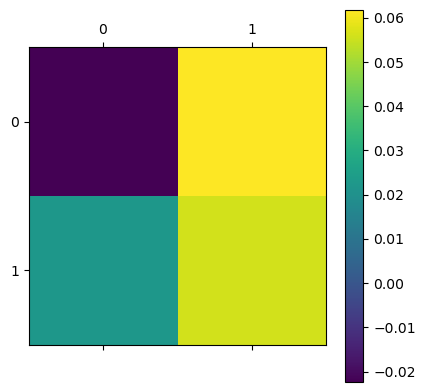

In [27]:
plt.matshow(model.variational_strategy.lmc_coefficients.t().detach())
plt.colorbar()

In [28]:
indices = torch.randperm(X_test.size(0))[:2000]
X_test_subsample = X_test[indices,:]
task_test_subsample = task_test[indices]
#X_test_flipped = torch.index_select(X_test, -1, permutation)
y_test_subsample = y_test[indices]
#y_test.max()

In [29]:
y_test_subsample

tensor([0.8440, 0.6042, 0.1898,  ..., 0.2412, 0.4450, 0.9848])

In [30]:
# Set into eval mode
model.eval()
likelihood.eval()
# Make predictions

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_max_tries(12):
    predictions = likelihood(model(X_test_subsample, task_indices = task_test_subsample))
    mean = predictions.mean
    #lower, upper = predictions.confidence_region()



In [31]:
#plt.plot(y_test)

In [32]:
#plt.plot(mean)

In [33]:
likelihood.noise

tensor([0.0059], grad_fn=<AddBackward0>)

In [39]:
model.covar_module_concentrations.lengthscale

tensor([[[0.2643]],

        [[0.3061]]], grad_fn=<SoftplusBackward0>)

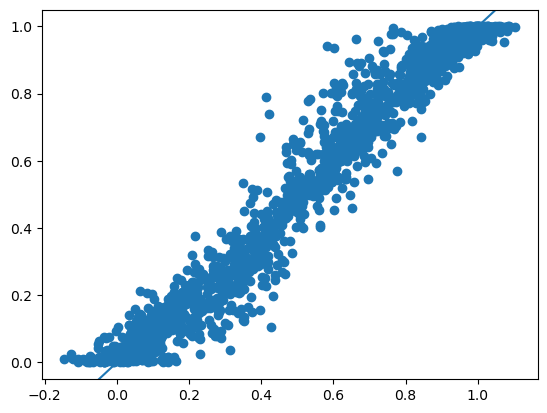

In [35]:
plt.scatter(mean,y_test_subsample)
plt.axline((0,0), slope=1)

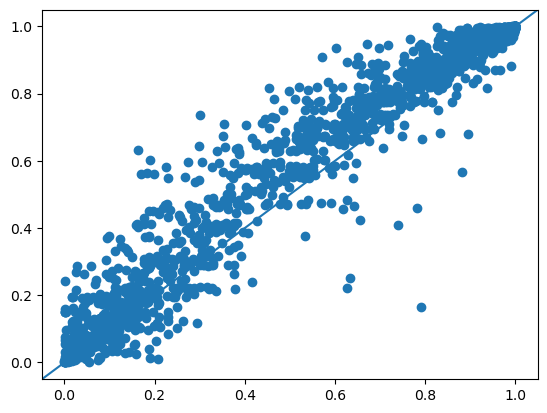

In [36]:
plt.scatter(y_test_subsample,torch.tensor(data["p0Mean"].values).float()[randperm[n_train:]][indices])
plt.axline((0,0), slope=1)

In [37]:
np.corrcoef(y_test_subsample,torch.tensor(data["p0Mean"].values).float()[randperm[n_train:]][indices])

array([[1.        , 0.97538101],
       [0.97538101, 1.        ]])

In [38]:
np.corrcoef(mean,y_test_subsample)

array([[1.        , 0.98301632],
       [0.98301632, 1.        ]])

In [43]:
torch.save({'model_state_dict': model.state_dict(),
            'likelihood_state_dict': likelihood.state_dict()},'LMC_ONeil_2Latents.pth')

In [41]:
likelihood.state_dict()

OrderedDict([('noise_covar.raw_noise', tensor([-5.1450])),
             ('noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('noise_covar.raw_noise_constraint.upper_bound', tensor(inf))])